### 필요한 라이브러리 import

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dropout,Dense,Bidirectional,TimeDistributed,Activation
from tensorflow.keras.utils import plot_model
from tensorflow import keras

from sklearn.metrics import mean_absolute_percentage_error

# 한글 폰트 설정
plt.rcParams["font.family"] = "Malgun Gothic"



In [2]:
df = pd.read_csv('Data_repositori/Source_data/전처리데이터.csv')
df.head()

,Unnamed: 0,일시,공급능력(MW),현재수요(MW),최대예측수요(MW),공급예비력(MW),공급예비율(퍼센트),운영예비력(MW),운영예비율(퍼센트),지점,기온(°C),1분 강수량(mm),강수유무(유무),풍향(deg),풍속(m/s),현지기압(hPa),해면기압(hPa),습도(%),일사(MJ/m^2),일조(Sec)
0,0,2018-01-01 00:00,97257.0,60955.0,62000,36302.0,59.5553,26023.0,42.6921,675.554902,-2.028487,0.0,0.0,202.466732,1.967850,1006.420000,1026.046452,59.107339,0.150841,884.872274
1,1,2018-01-01 00:05,97257.0,60964.3,62000,36292.7,59.5310,26013.7,42.6703,675.013752,-2.066535,0.0,0.0,204.545759,1.914625,1006.416129,1026.045161,59.397853,0.018350,1.869159
2,2,2018-01-01 00:10,97257.0,60745.9,62000,36511.1,60.1046,26232.1,43.1833,675.013752,-2.090748,0.0,0.0,197.610454,1.916798,1006.416774,1026.049032,59.438650,0.018608,3.738318
3,3,2018-01-01 00:15,97257.0,60170.5,62000,37086.5,61.6357,26807.5,44.5526,675.013752,-2.116732,0.0,0.0,195.935700,1.929644,1006.423871,1026.062581,59.450613,0.018770,5.607477
4,4,2018-01-01 00:20,97257.0,60067.7,62000,37189.3,61.9123,26910.3,44.7999,675.013752,-2.149409,0.0,0.0,190.832347,1.900593,1006.429032,1026.072903,59.575460,0.018511,7.476636


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561482 entries, 0 to 561481
Data columns (total 20 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  561482 non-null  int64  
 1   일시          561482 non-null  object 
 2   공급능력(MW)    561482 non-null  float64
 3   현재수요(MW)    561482 non-null  float64
 4   최대예측수요(MW)  561482 non-null  int64  
 5   공급예비력(MW)   561482 non-null  float64
 6   공급예비율(퍼센트)  561482 non-null  float64
 7   운영예비력(MW)   561482 non-null  float64
 8   운영예비율(퍼센트)  561482 non-null  float64
 9   지점          561482 non-null  float64
 10  기온(°C)      561482 non-null  float64
 11  1분 강수량(mm)  561482 non-null  float64
 12  강수유무(유무)    561482 non-null  float64
 13  풍향(deg)     561482 non-null  float64
 14  풍속(m/s)     561482 non-null  float64
 15  현지기압(hPa)   561482 non-null  float64
 16  해면기압(hPa)   561482 non-null  float64
 17  습도(%)       561482 non-null  float64
 18  일사(MJ/m^2)  561482 non-null  float64
 19  일조

### 데이터 전처리 및 데이터 정제

In [5]:
df=df[['일시','현재수요(MW)','기온(°C)','강수유무(유무)','습도(%)']]

In [8]:
df.reset_index(drop=True,inplace=True)

In [9]:
df['일시']=pd.to_datetime(df['일시'])

In [10]:
# df['year']=df['일시'].dt.year
df['month']=df['일시'].dt.month
df['day']=df['일시'].dt.day
df['hour']=df['일시'].dt.hour

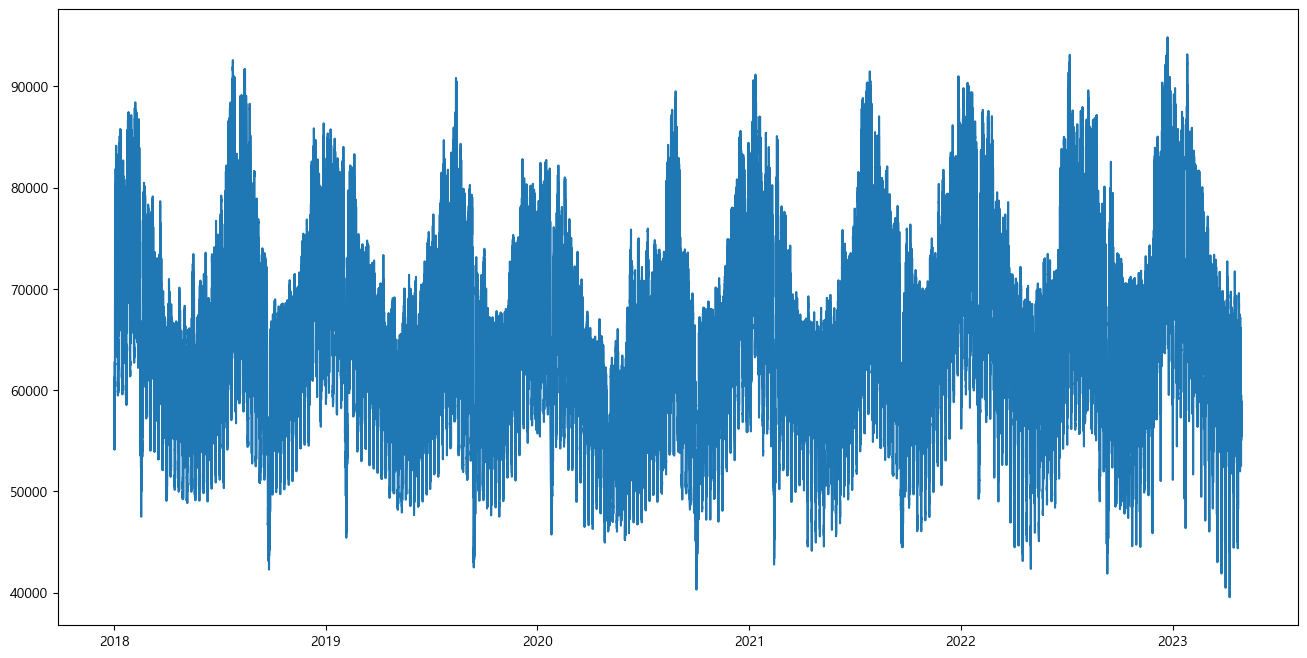

In [11]:
df.index = df['일시']
plt.figure(figsize=(16,8))
plt.plot(df['현재수요(MW)'],label='5분단위')

#### 데이터 정규화

In [12]:
new_dataset = df.loc[:,['현재수요(MW)','month','hour','기온(°C)','강수유무(유무)','습도(%)']]

In [13]:
min_ds = new_dataset.min()
max_ds = new_dataset.max()
scaled_data = ((new_dataset - min_ds)/(max_ds-min_ds))   ### MinMaxScaler 대체 각 값을 0에서 1로 정규화

In [15]:
future_data=scaled_data['2023-03-19 18:00':'2023-03-19 23:55'].values 

#### 훈련 데이터, 테스트 데이터 분류

In [146]:
train_data = scaled_data[:'2023-03-12'].values
test_data = scaled_data['2023-03-12 18:00:00':'2023-03-19'].values
scale_shape = scaled_data.shape[-1]  # 데이터 차원 변수에 저장

In [18]:
x_train,y_train=[],[]
x_test,y_test = [],[]

# 훈련 데이터 처리
for i in range(72,len(train_data)-72):
    x_train.append(train_data[i-72:i,])   # 현재 시점 이전 72개 데이터를 입력값으로 추가
    y_train.append(train_data[i:i+72,0])  # 현재 시점부터 다음 72개 데이터의 첫 번째 열 값을 출력값으로 추가

# 테스트 데이터 처리
for i in range(72,len(test_data)-72+1,72):
    x_test.append(test_data[i-72:i,])     # 현재 시점 이전 72개 데이터를 입력값으로 추가
    y_test.append(test_data[i:i+72,0])    # 현재 시점부터 다음 72개 데이터의 첫 번째 열 값을 출력값으로 추가


In [19]:
# NumPy 배열로 변환
x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)

# 훈련 데이터의 형태 재구성
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], scale_shape))


### LSTM 모델 구성

In [20]:
model = Sequential([
    Bidirectional(LSTM(64, input_shape=(72, scale_shape), return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(32, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(16, return_sequences=True)),
    TimeDistributed(Dense(32)),
    TimeDistributed(Dense(1)),
    Activation('sigmoid'),
])
model.build(input_shape=(None, 72, scale_shape))

model.compile(loss='mean_absolute_percentage_error', optimizer='adam', metrics=['mae'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 72, 128)          36352     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 72, 128)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 72, 64)           41216     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 72, 64)            0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 72, 32)           10368     
 nal)                                                            
                                                        

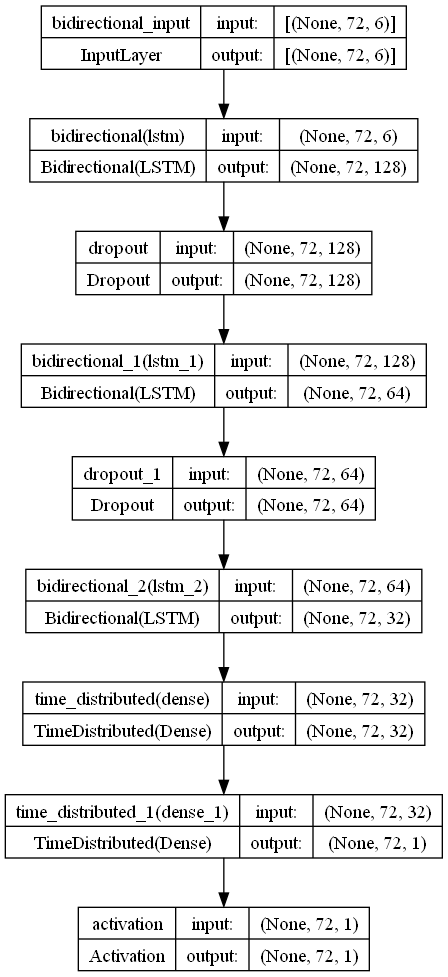

In [21]:
plot_model(model,show_shapes=True)

In [22]:
from keras.callbacks import ModelCheckpoint

In [23]:
md_chk = ModelCheckpoint('best0710.h5',monitor='val_mae',save_best_only=True,verbose=1)

In [24]:
history = model.fit(x_train,y_train,batch_size=256,validation_data=(x_test,y_test),epochs=200,callbacks=[md_chk])

Epoch 1/200
2138/2139 [============================>.] - ETA: 0s - loss: 8.5233 - mae: 0.0352
Epoch 1: val_mae improved from inf to 0.03656, saving model to best0710.h5
2139/2139 [==============================] - 105s 44ms/step - loss: 8.5226 - mae: 0.0352 - val_loss: 11.4783 - val_mae: 0.0366
Epoch 2/200
2138/2139 [============================>.] - ETA: 0s - loss: 6.4424 - mae: 0.0265
Epoch 2: val_mae improved from 0.03656 to 0.03327, saving model to best0710.h5
2139/2139 [==============================] - 94s 44ms/step - loss: 6.4423 - mae: 0.0265 - val_loss: 10.0431 - val_mae: 0.0333
Epoch 3/200
2138/2139 [============================>.] - ETA: 0s - loss: 5.9493 - mae: 0.0244
Epoch 3: val_mae did not improve from 0.03327
2139/2139 [==============================] - 92s 43ms/step - loss: 5.9492 - mae: 0.0244 - val_loss: 11.1378 - val_mae: 0.0348
Epoch 4/200
2138/2139 [============================>.] - ETA: 0s - loss: 5.6088 - mae: 0.0230
Epoch 4: val_mae did not improve from 0.03327

Text(0, 0.5, 'mape')

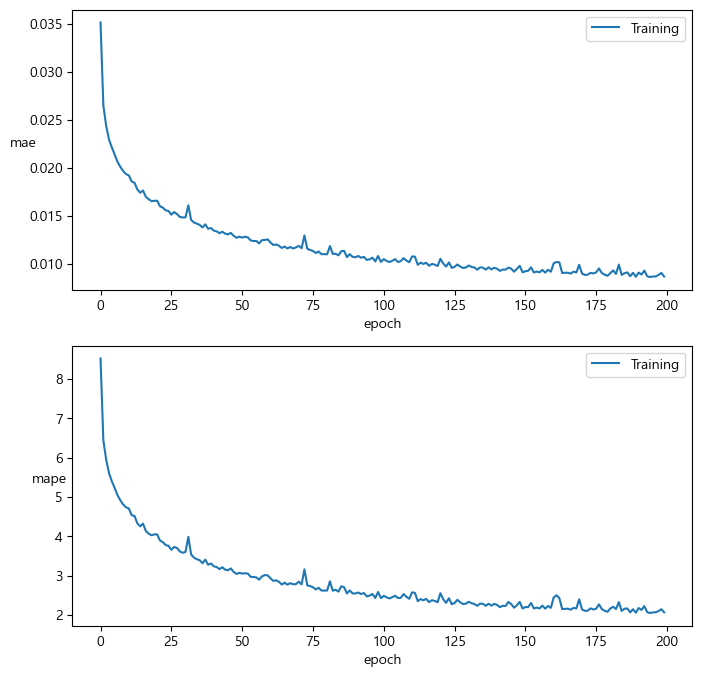

In [133]:
mae = history.history['mae']
val_mae = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(mae,label='Training')
# plt.plot(val_mae,label='Validation')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('mae',rotation=0)

plt.subplot(2, 1, 2)
plt.plot(loss,label='Training')
# plt.plot(val_loss,label='Validation')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('mape',rotation=0)


In [134]:
# 평가 
loss,mae = model.evaluate(x_test,y_test)

1/1 [==============================] - 2s 2s/step - loss: 5.2062 - mae: 0.0189


#### 분석 대상 기간 : ‘23.3.13(월) ~ 3.19(일)(1주일)

In [136]:
pred=model.predict(x_test)

1/1 [==============================] - 0s 36ms/step


In [137]:
y_test_reshape = y_test.reshape(-1,1)*(max_ds[0]-min_ds[0])+min_ds[0]
pred_reshape = pred.reshape(-1,1)*(max_ds[0]-min_ds[0])+min_ds[0]

In [159]:
mape = mean_absolute_percentage_error(y_test_reshape, pred_reshape)
print("분석 대상 기간 MAPE: {:.2f}%".format(mape * 100))

분석 대상 기간 MAPE: 1.68%


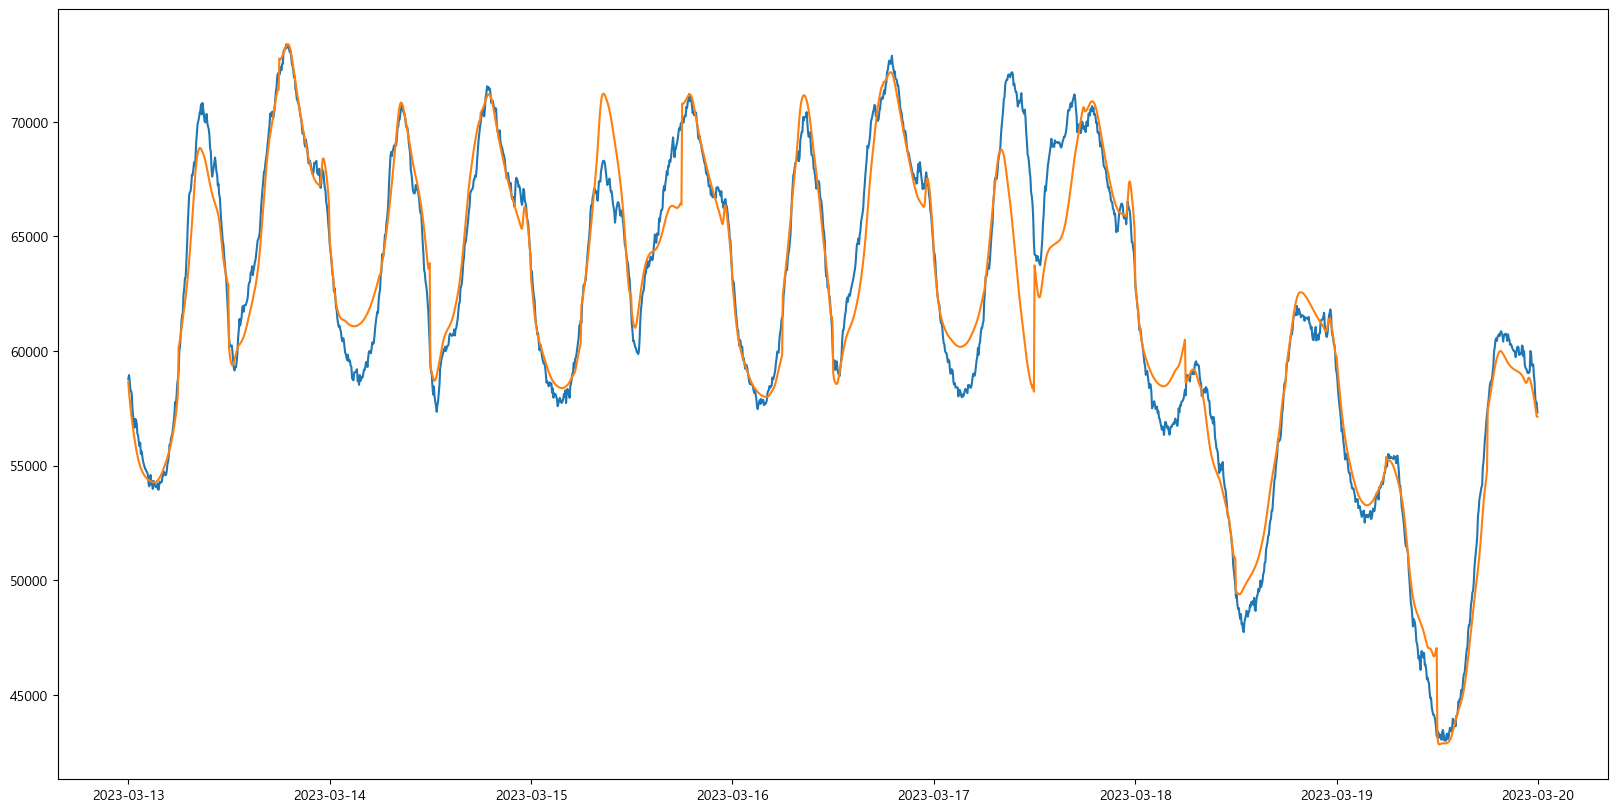

In [160]:
plt.plot(pd.date_range("2023-03-13","2023-03-19 23:55:00",freq="5T"),y_test_reshape) # 파랑 
plt.plot(pd.date_range("2023-03-13","2023-03-19 23:55:00",freq="5T"),pred_reshape) # 주황

In [ ]:
# model.load('lstm.h5') ## 모델 저장

### 저장한 모델 불러오기

In [235]:
model = keras.models.load_model('best.h5')

In [236]:
# 예측
pred = model.predict(x_test)

# 데이터 역정규화 작업 실시
y_test_reshape = y_test.reshape(-1,1)*(max_ds[0]-min_ds[0])+min_ds[0]   
pred_reshape = pred.reshape(-1,1)*(max_ds[0]-min_ds[0])+min_ds[0]  

1/1 [==============================] - 1s 1s/step


#### MAPE

In [243]:
mape = mean_absolute_percentage_error(y_test_reshape, pred_reshape)
print("분석 대상 기간 MAPE: {:.2f}%".format(mape * 100))

분석 대상 기간 MAPE: 1.68%


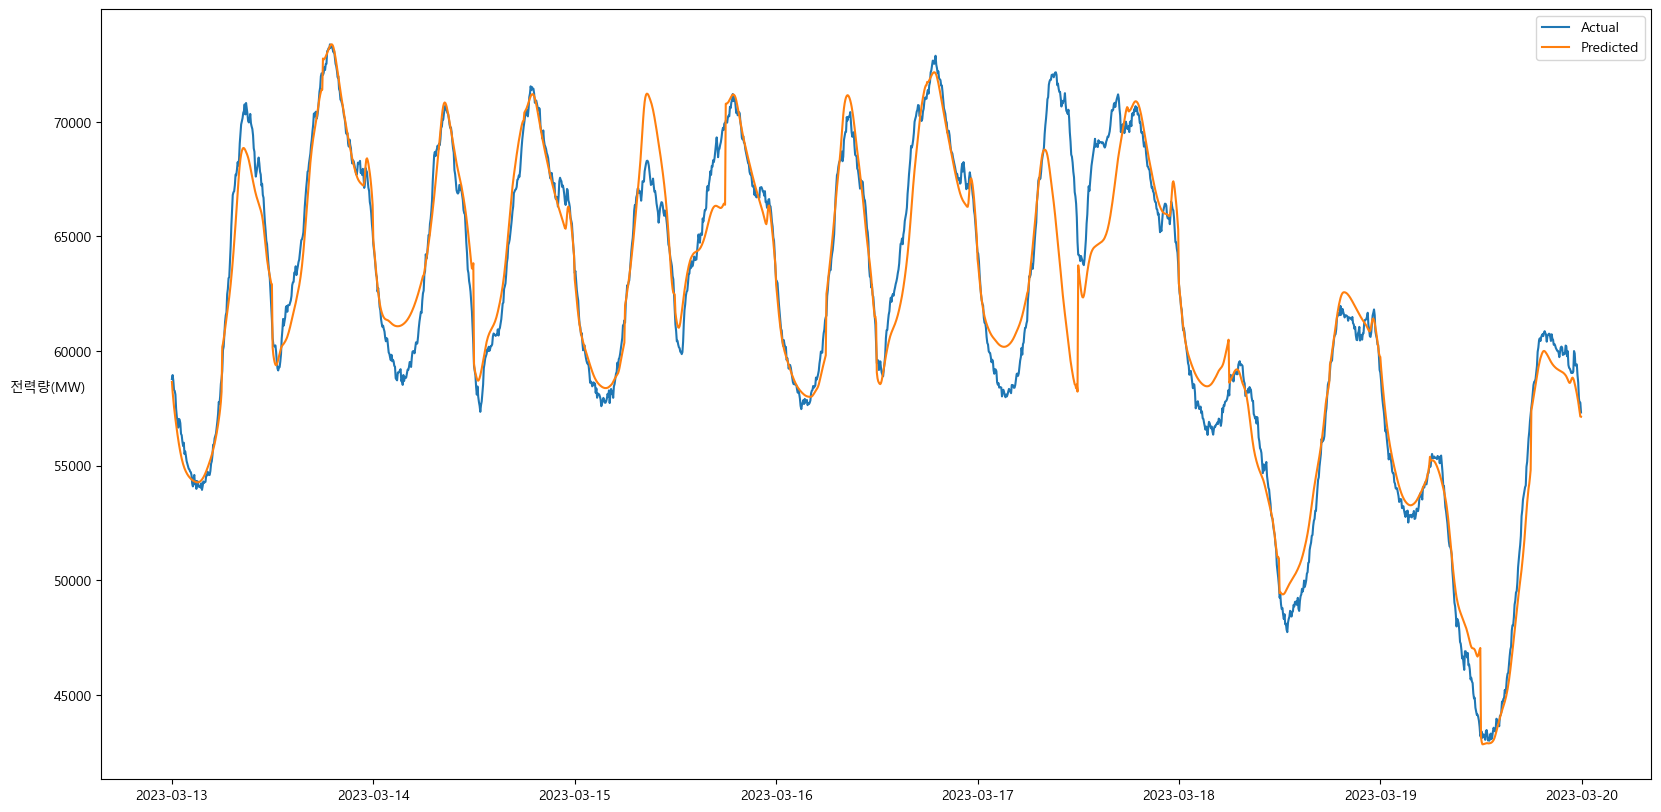

In [158]:
plt.plot(pd.date_range("2023-03-13","2023-03-19 23:55:00",freq="5T"),y_test_reshape,label = "Actual") # 파랑 
plt.plot(pd.date_range("2023-03-13","2023-03-19 23:55:00",freq="5T"),pred_reshape, label= "Predicted") # 주황
plt.ylabel("전력량(MW)", rotation=0)
plt.legend(loc="upper right")

# plt.savefig("elc.png")

#### 분석 대상 기간 예측 실적치 와 MAPE

In [252]:
start_date = '2023-03-13'
end_date = '2023-03-19 23:55:00'
dates = pd.date_range(start=start_date, end=end_date, freq='5min')
pred_rounded = np.round(pred_reshape.flatten(), decimals=2)

# 예측 실적치와 날짜 정보를 데이터프레임으로 변환
df_pred = pd.DataFrame({'일시': dates, '예측 전력 수요(MW)': pred_rounded})

df_pred['현재수요(MW)'] = new_dataset.loc['2023-03-13':'2023-03-19', '현재수요(MW)'].values

df_pred['예측 전력 수요(MW)'] = df_pred['예측 전력 수요(MW)'].round(2)
mape = mean_absolute_percentage_error(df_pred['현재수요(MW)'], df_pred['예측 전력 수요(MW)'])

# MAPE 값을 새로운 열로 추가
df_pred['MAPE'] = (mape * 100).round(2)
df_pred

,일시,예측 전력 수요(MW),현재수요(MW),MAPE
0,2023-03-13 00:00:00,58655.468750,58782.03,1.68
1,2023-03-13 00:05:00,58215.539062,58954.44,1.68
2,2023-03-13 00:10:00,57869.261719,58710.58,1.68
3,2023-03-13 00:15:00,57569.460938,58298.44,1.68
4,2023-03-13 00:20:00,57296.429688,58263.70,1.68
...,...,...,...,...
2011,2023-03-19 23:35:00,57792.699219,58627.16,1.68
2012,2023-03-19 23:40:00,57585.488281,57941.24,1.68
2013,2023-03-19 23:45:00,57361.960938,57726.21,1.68
2014,2023-03-19 23:50:00,57147.808594,57755.40,1.68


In [251]:
# df_pred.to_csv('분석 대상 기간 예측 실적치와 MAPE.csv')

### 향후 6시간 예측 (2023-03-20 00:00 ~ 2023-03-20 05:55)

In [150]:
load_pred = (model.predict(future_data.reshape(1,72,6))).reshape(-1,1)*(max_ds[0]-min_ds[0])+min_ds[0]

1/1 [==============================] - 0s 38ms/step


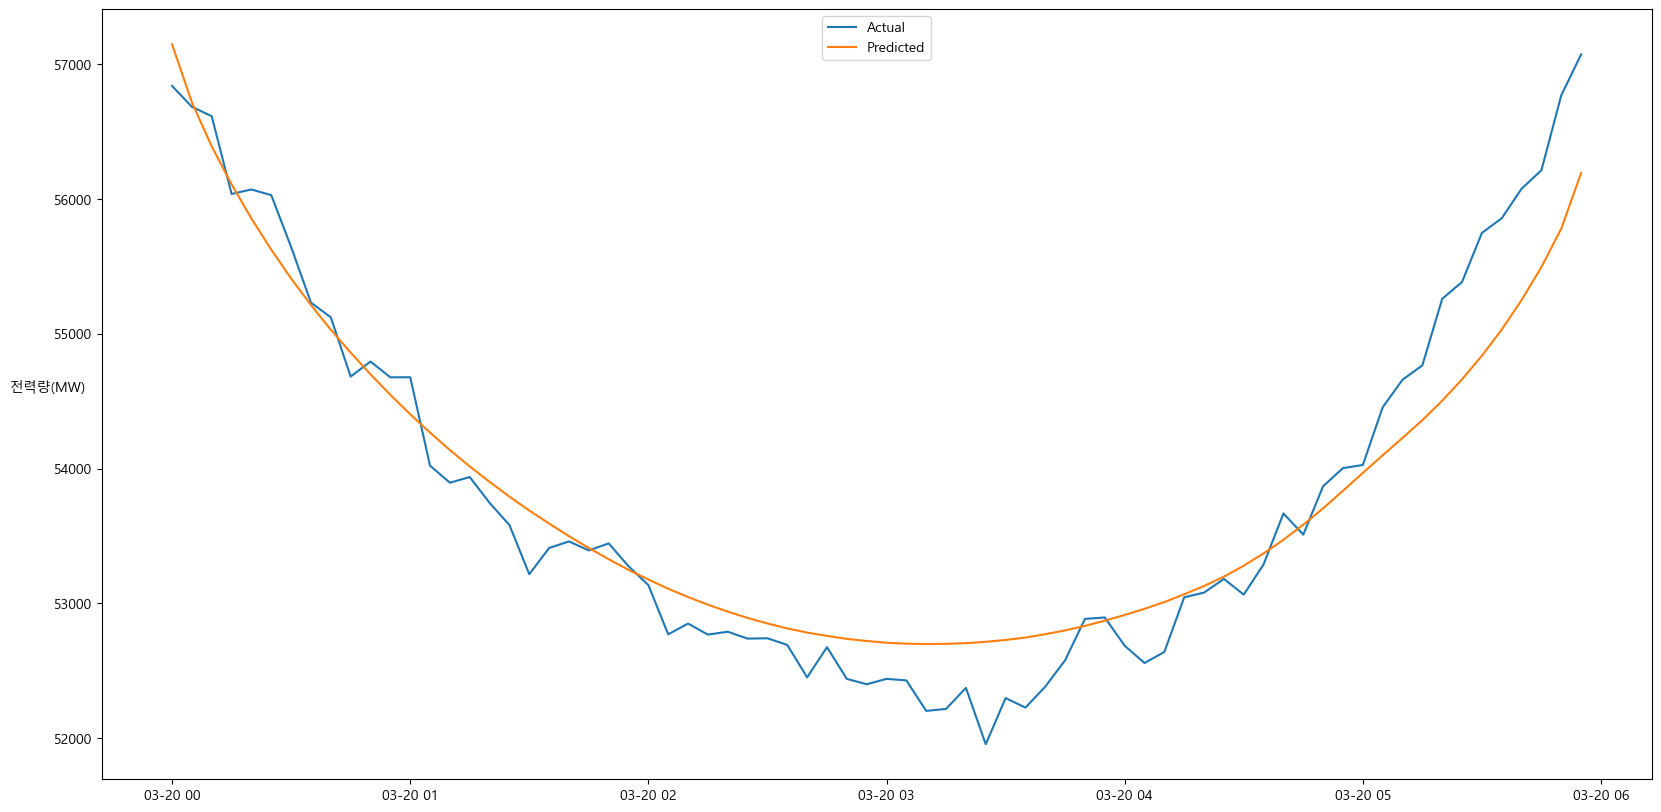

In [151]:
plt.plot(pd.date_range("2023-03-20 00:00","2023-03-20 05:55",freq="5T"),f_test,label = "Actual")
plt.plot(pd.date_range("2023-03-20 00:00","2023-03-20 05:55",freq="5T"),load_pred, label= "Predicted")
plt.ylabel("전력량(MW)", rotation=0)
plt.legend(loc="upper center")
plt.savefig("elc.png")

In [153]:
mape = mean_absolute_percentage_error(f_test, load_pred)
print("분석 대상 기간 MAPE: {:.2f}%".format(mape * 100))

분석 대상 기간 MAPE: 0.53%
